In [1]:
import os, sys
import json
import tarfile
import shutil

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import time
from time import mktime
import datetime

In [2]:
# NLR

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -d C:\Users\myaun\Downloads\ipadic-neologd")

import re
import unicodedata
import neologdn

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.font_manager as fm
fm.findSystemFonts()
font = {"family":"IPAexGothic"}
mpl.rc('font', **font)

In [4]:
# normarize

def clean_text(text):
    #replaced_text = '\n'.join(s.strip() for s in text.splitlines()[2:] if s != '')  # skip header by [2:]
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    #replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text=re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", replaced_text)
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

def normalize_text( text ):
    text = clean_text(text)
    text = unicodedata.normalize('NFC', text)
    text = neologdn.normalize(text)   
    return text

# tokenize

def get_tokens_pos( text, target_pos ):
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        if pos in target_pos:
            tokens.append( result.surface )
        result = result.next
    return tokens

In [5]:
def load_tweets( query ):
    query_dir = "%s/%s" % (savepath, query)
    if not os.path.exists( query_dir ):
        os.mkdir(query_dir)

    rows = []
    files = os.listdir(query_dir)
    for idx, file in enumerate(files):
        if os.path.isfile( "%s/%s" % (query_dir, file) ): # file
            taffile_path = "%s/%s" % (query_dir, file)
            tf = tarfile.open( taffile_path , 'r')
            for fname_in_tar in tf.getnames():
                f = tf.extractfile( fname_in_tar )
                tweet = json.loads( f.read().decode() )
                struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
                dt = datetime.datetime.fromtimestamp(mktime(struct))
                dt_diff = dt + datetime.timedelta(hours=9)
                rows.append( [dt_diff, tweet['id'], tweet['text']] )  
        else: # dir
            target_dir = "%s/%s" % (query_dir, file)
            files = os.listdir(target_dir)
            for idx, file in enumerate(files):
                f = open('%s/%s' % (target_dir, file), 'r')
                tweet = json.load(f)
                f.close()

                struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
                dt = datetime.datetime.fromtimestamp(mktime(struct))
                dt_diff = dt + datetime.timedelta(hours=9)
                rows.append( [dt_diff, tweet['id'], tweet['text']] )
    return rows

In [6]:
savepath =  "C:/Users/myaun/Desktop/twitter_stream/data/tweet"

query = "#黒い羊"
rows = load_tweets( query )
df= pd.DataFrame( rows, columns=['created_at', 'id', 'text'] )
onair_time = ['2019-01-21 22:30', '2019-01-21 23:59']
df_target = df.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))
texts = df_target['text'].values.tolist()
BoW = [ get_tokens_pos( normalize_text( text ), ['名詞','形容詞'] ) for text in texts ]

text = ""
for entities in BoW:
    for e in entities:
        text += '%s '%e

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image   # to import the image
fpath = "C:\Windows\Fonts\meiryob.ttc"

def get_wordcrowd( text ):
    wordcloud = WordCloud(background_color="black",
                          width=800,
                          height=600,
                          font_path=fpath,
                          collocations=False, # 単語の重複しないように
                         ).generate( text )

    # show
    plt.figure(figsize=(6,6), dpi=200)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

def get_wordcrowd_mask( text, imgpath ):
    img_color = np.array(Image.open( imgpath ))
    wc = WordCloud(width=800,
                   height=600,
                   font_path=fpath,
                   mask=img_color,
                   collocations=False, # 単語の重複しないように
                  ).generate( text )

    # show
    plt.figure(figsize=(6,6), dpi=200)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def get_wordcrowd_color_mask( text, imgpath ):
    img_color = np.array(Image.open( imgpath ))
    wc = WordCloud(width=800,
                   height=600,
                   font_path=fpath,
                   mask=img_color,
                   collocations=False, # 単語の重複しないように
                  ).generate( text )

    image_colors = ImageColorGenerator(img_color)
   
    # show
    plt.figure(figsize=(6,6), dpi=200)
    plt.imshow(wc.recolor(color_func=image_colors), # 元画像の色を使う
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

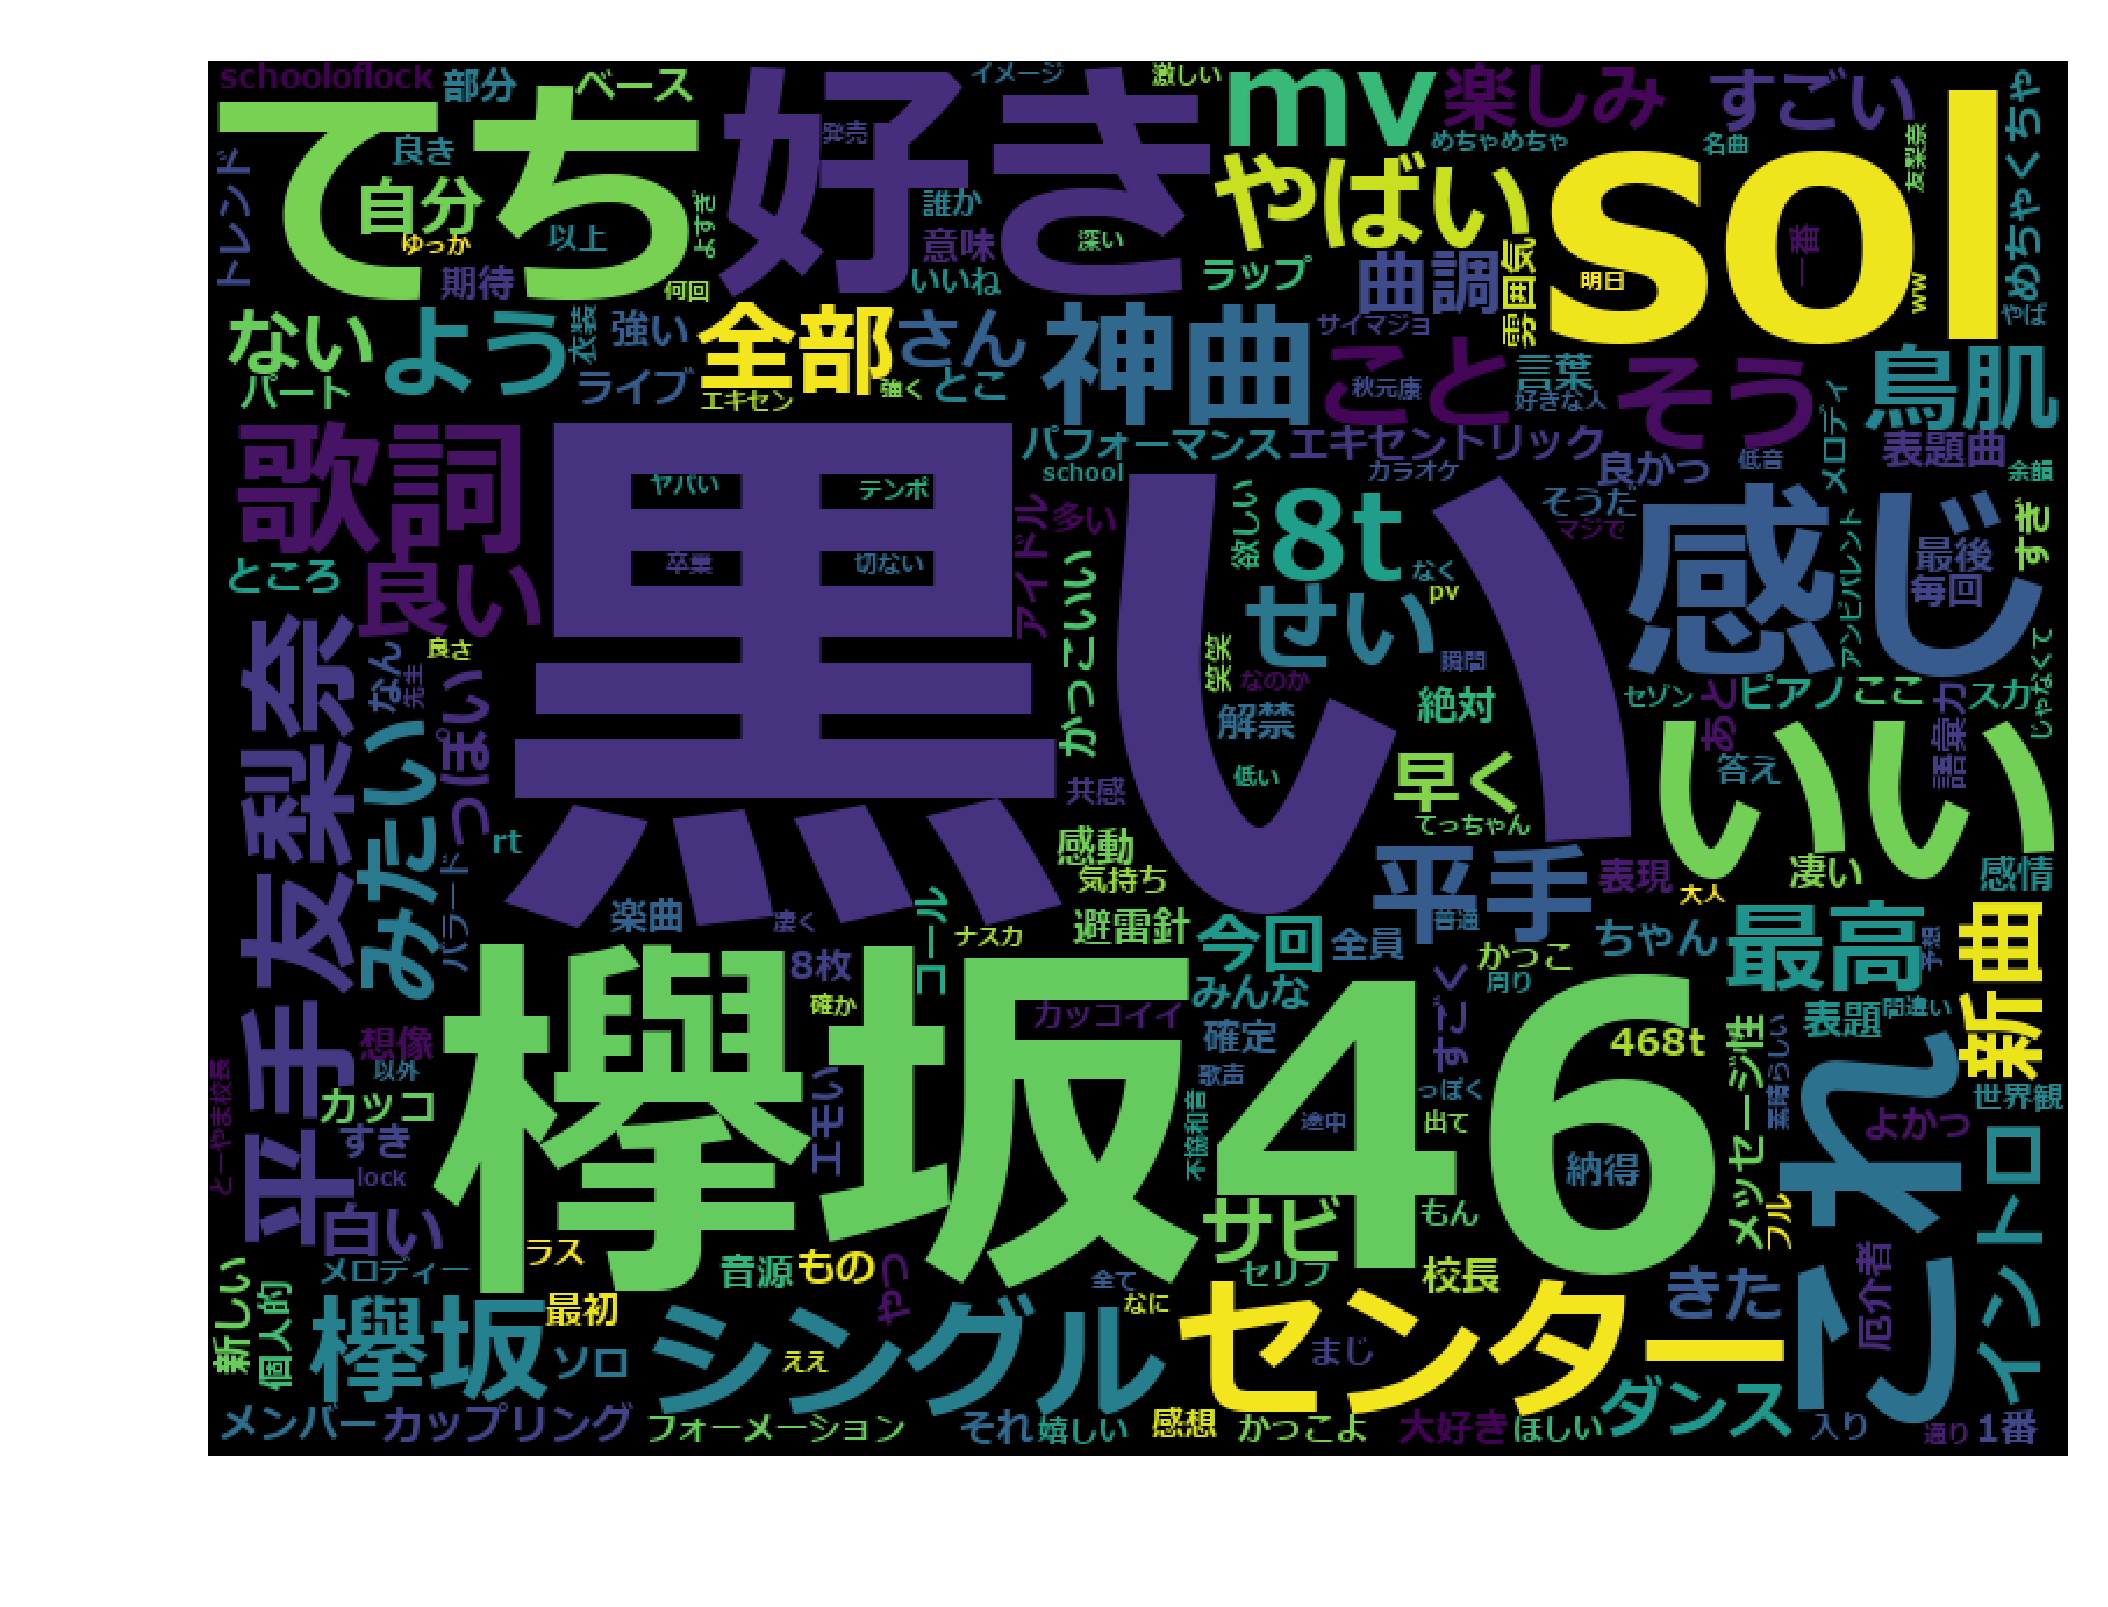

In [15]:
get_wordcrowd(text)

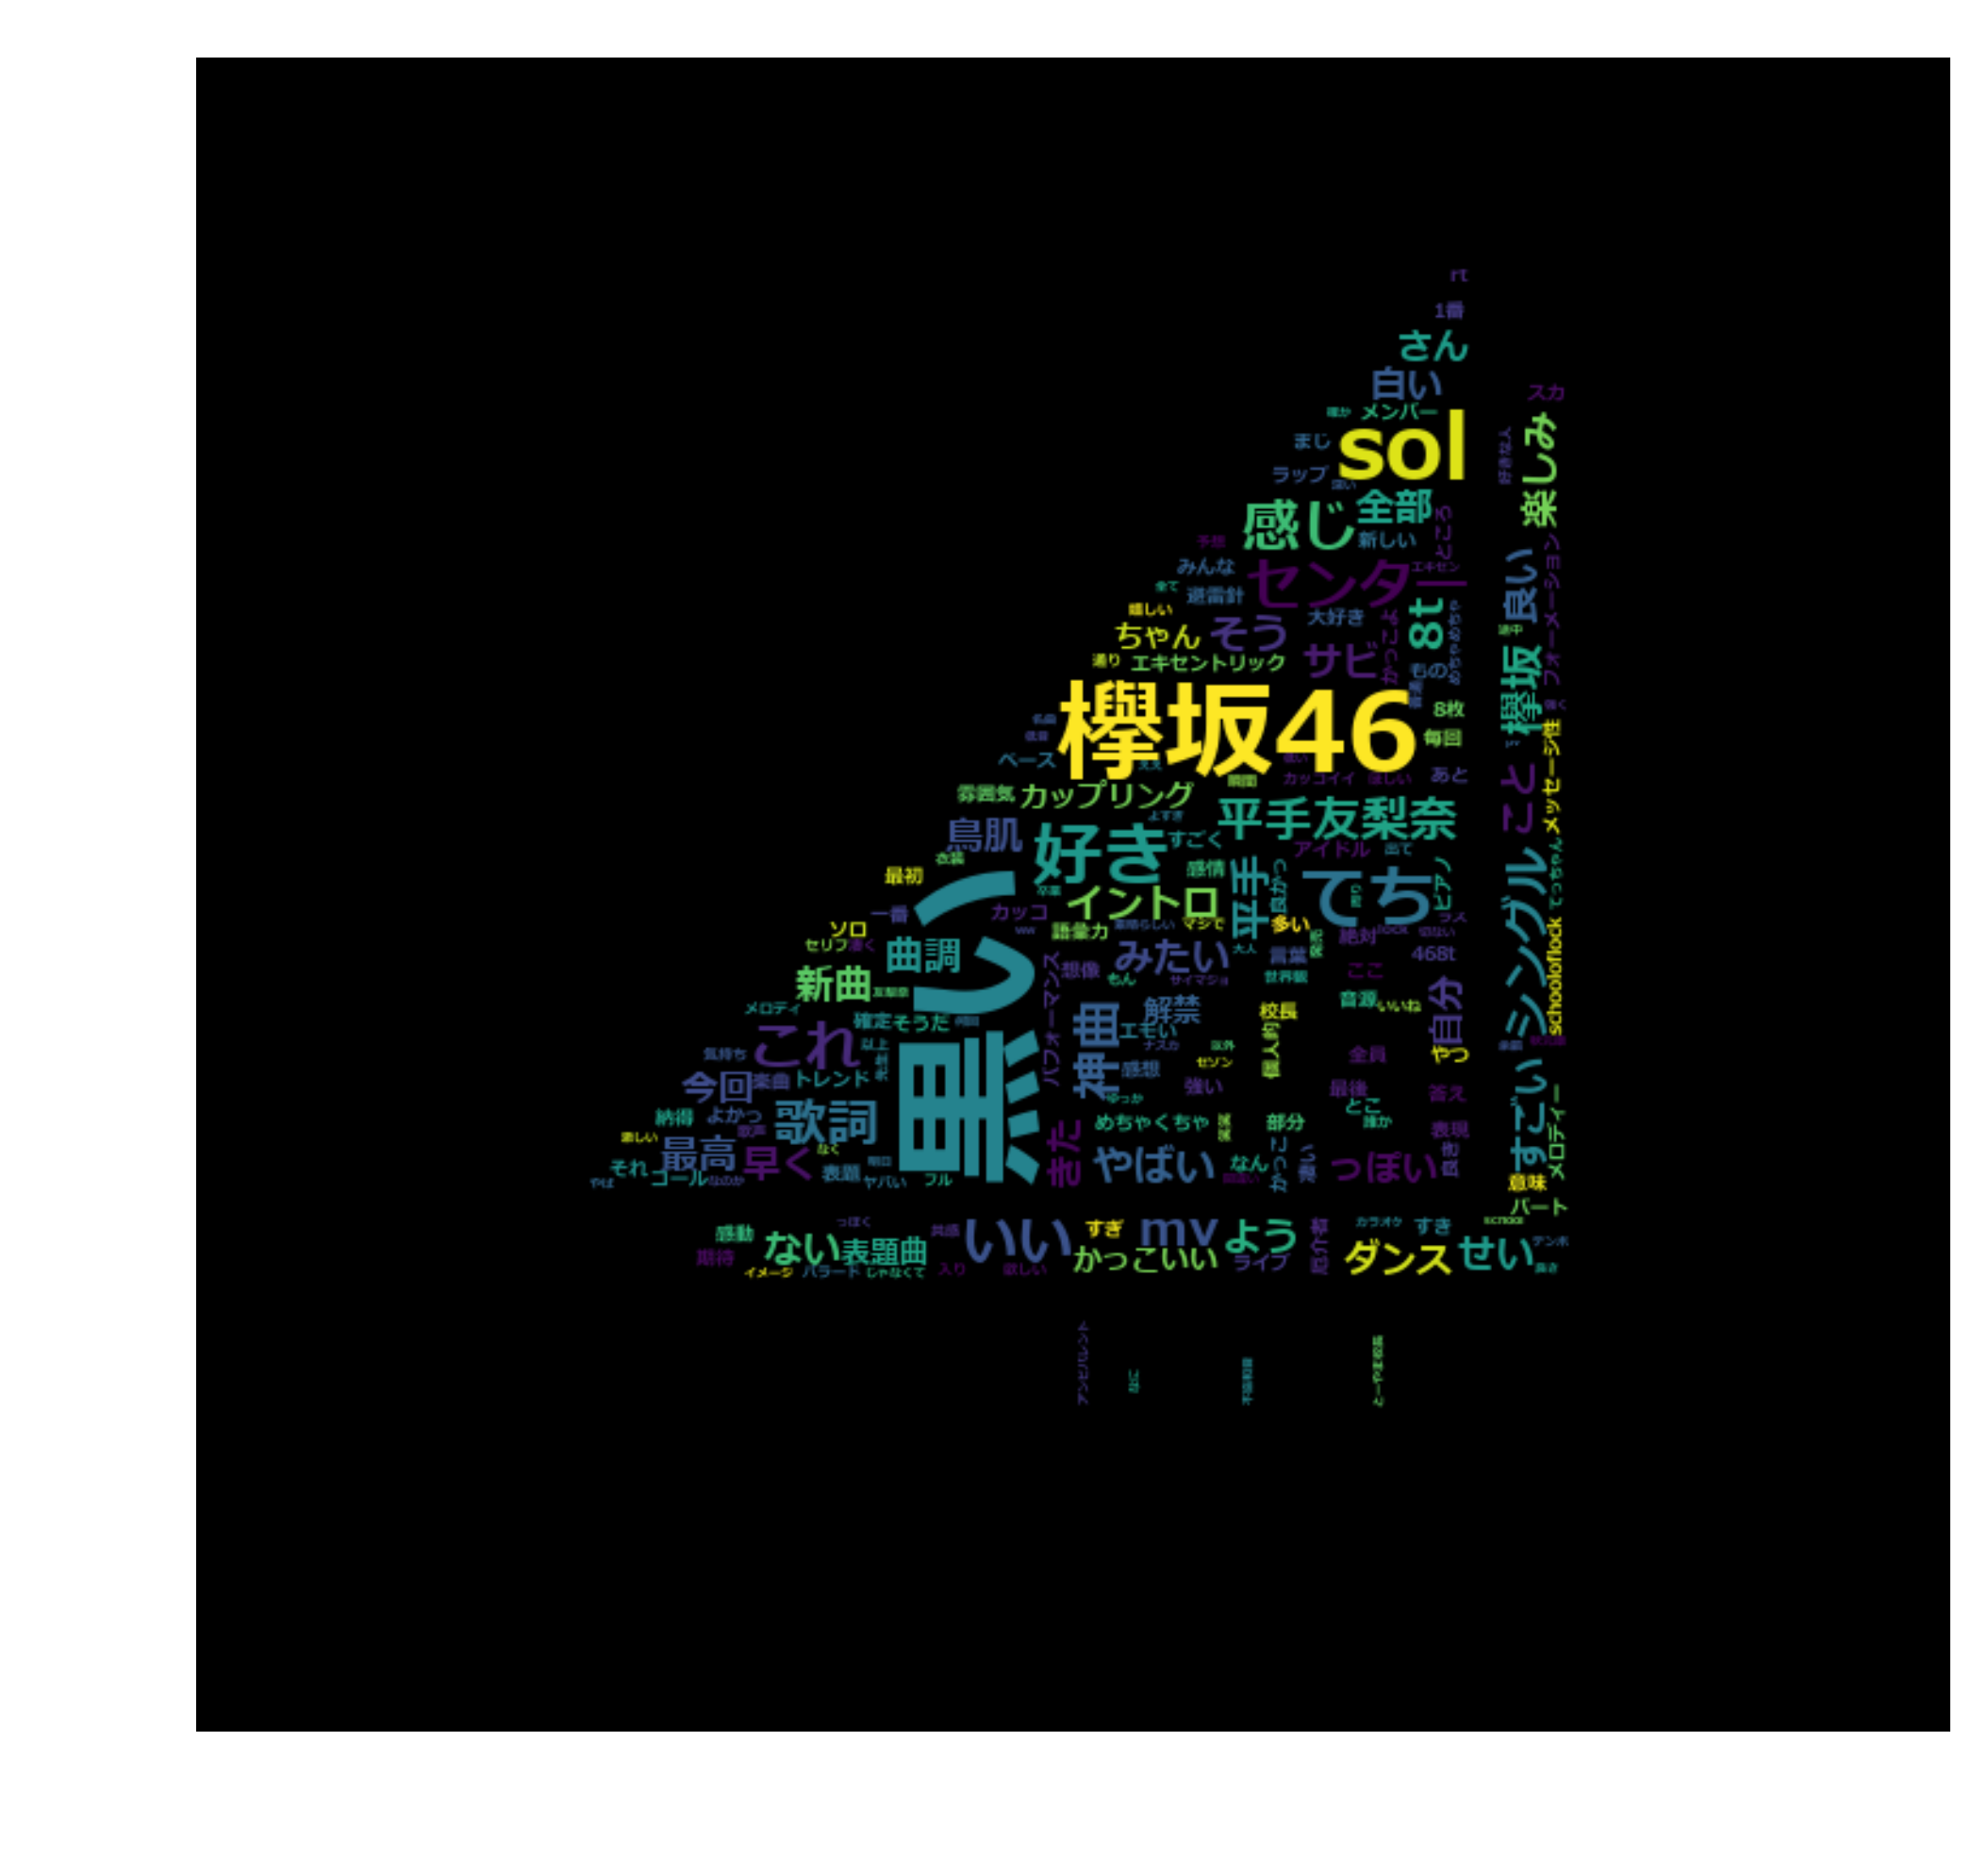

In [16]:
get_wordcrowd_mask(text, './mask_images/Keyakizaka46_logo_2.png')

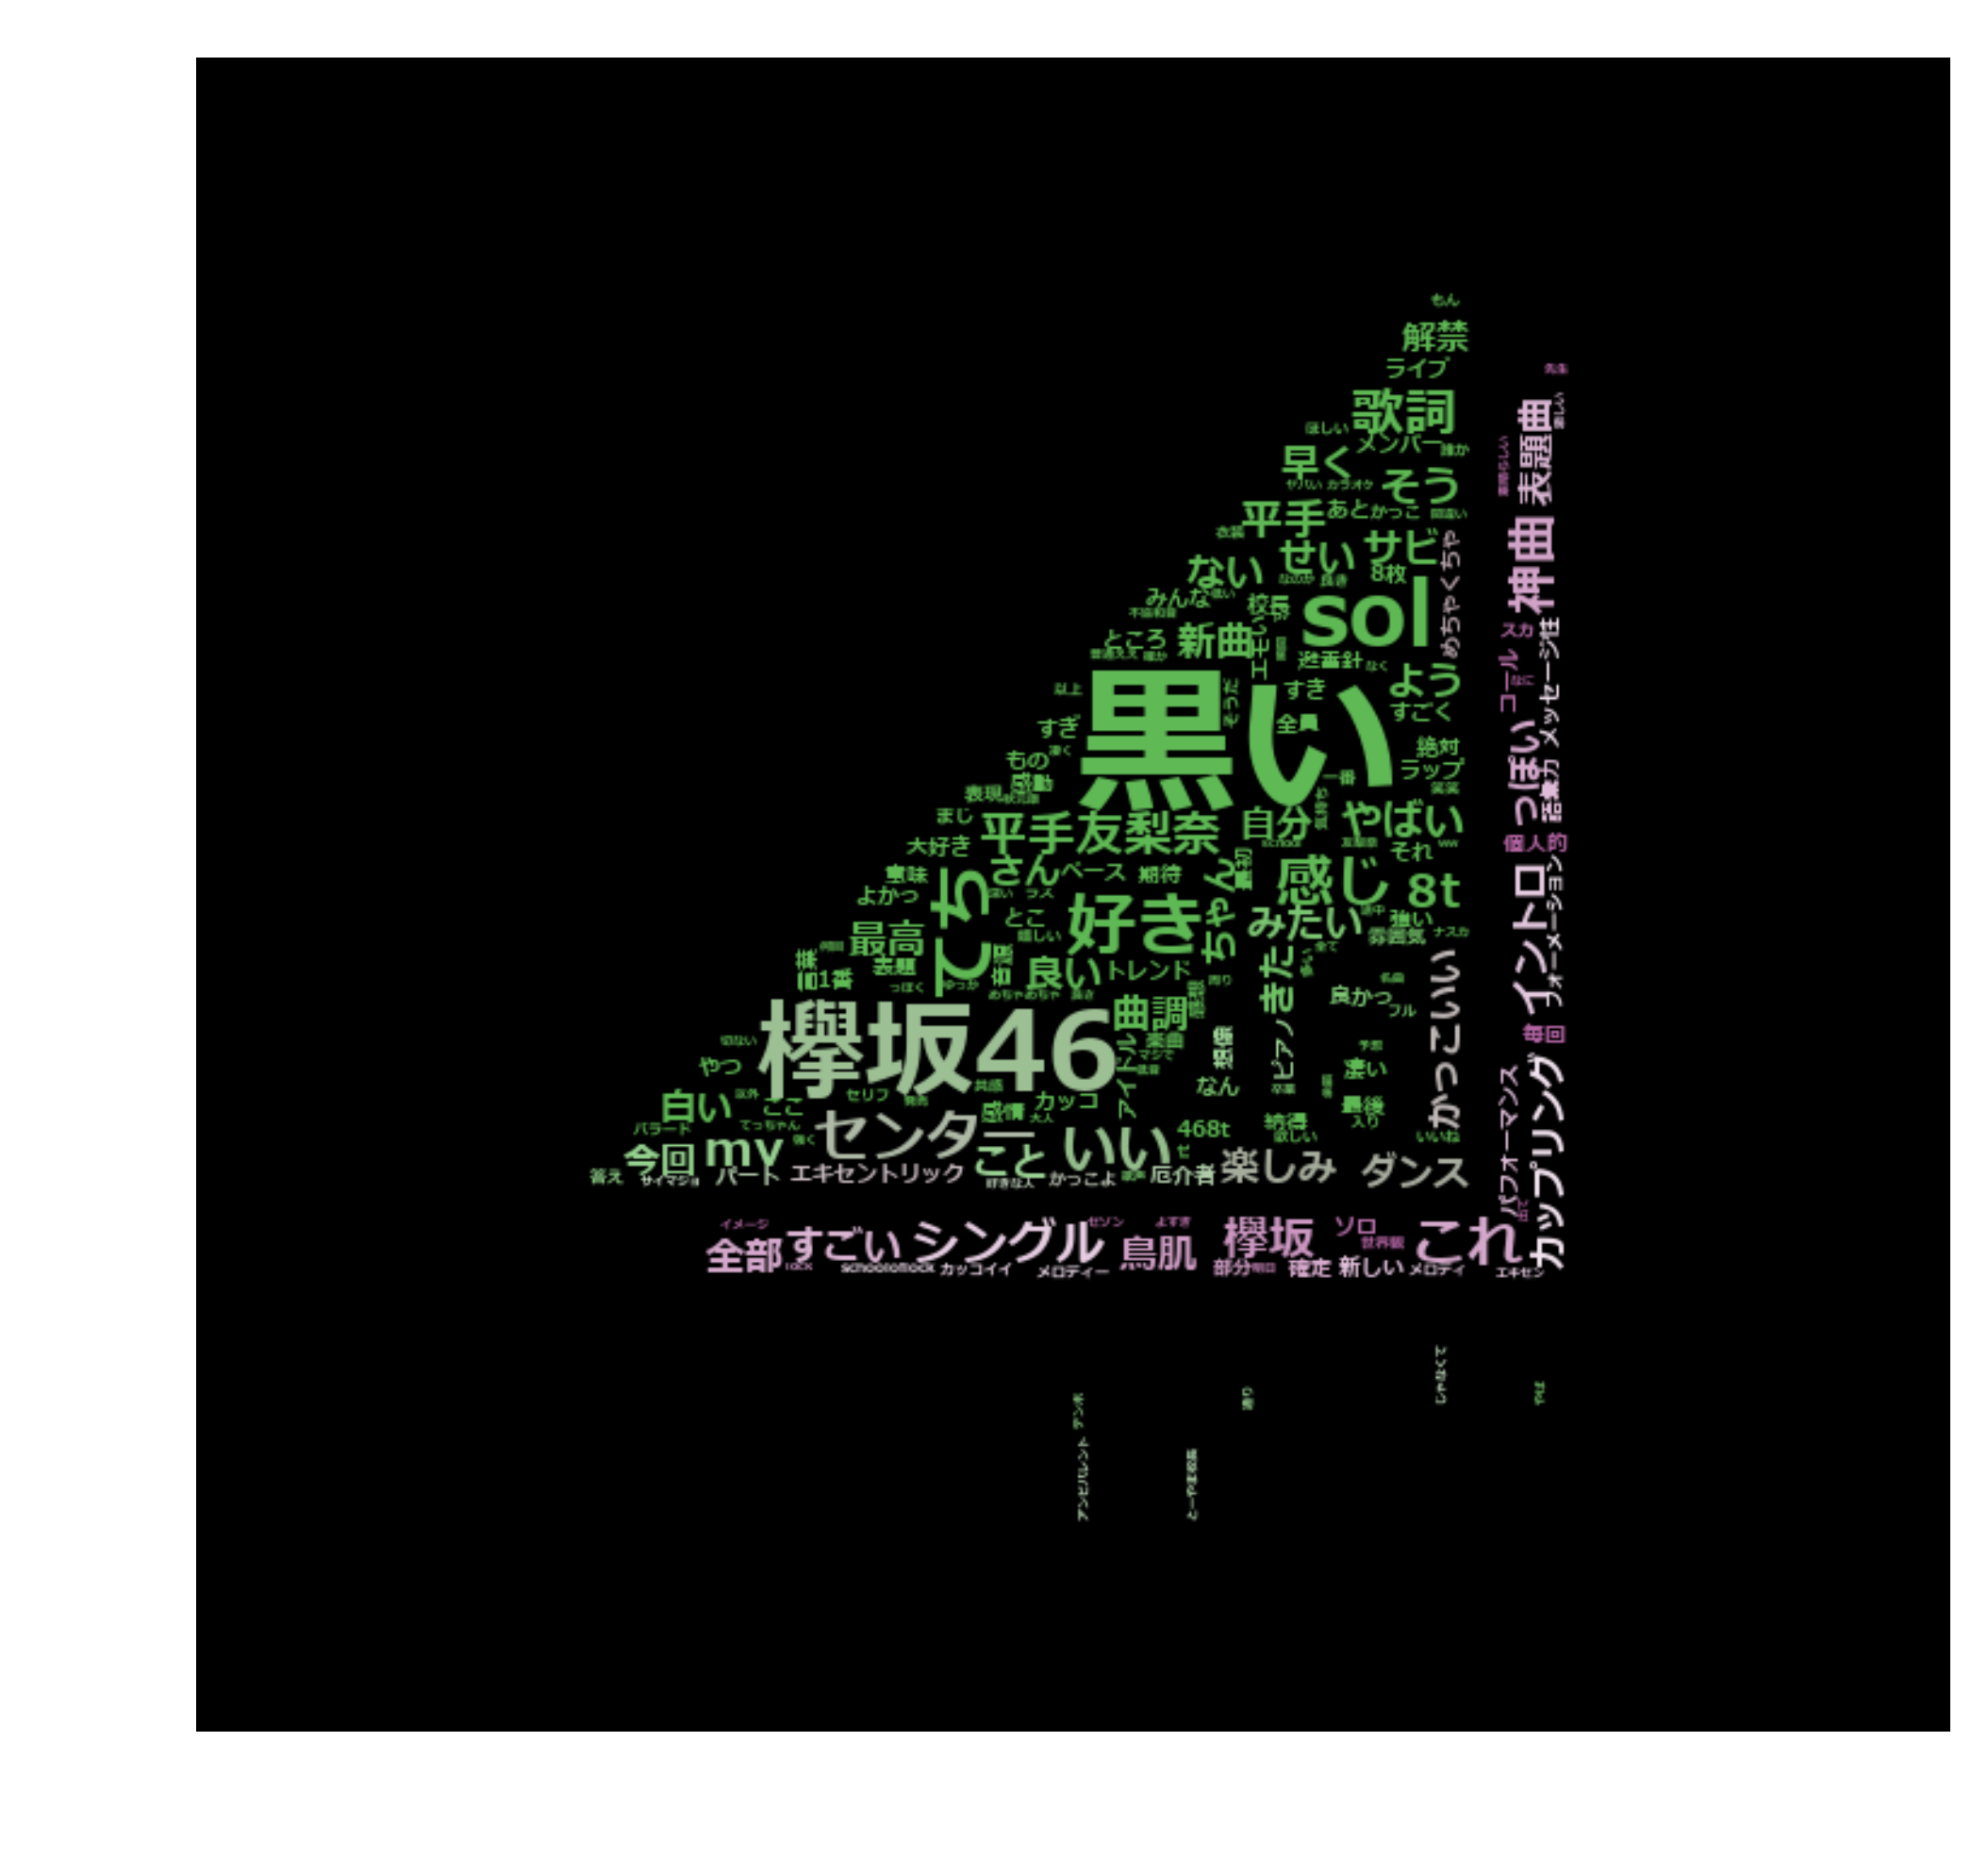

In [20]:
get_wordcrowd_color_mask(text, './mask_images/Keyakizaka46_logo_2.png')

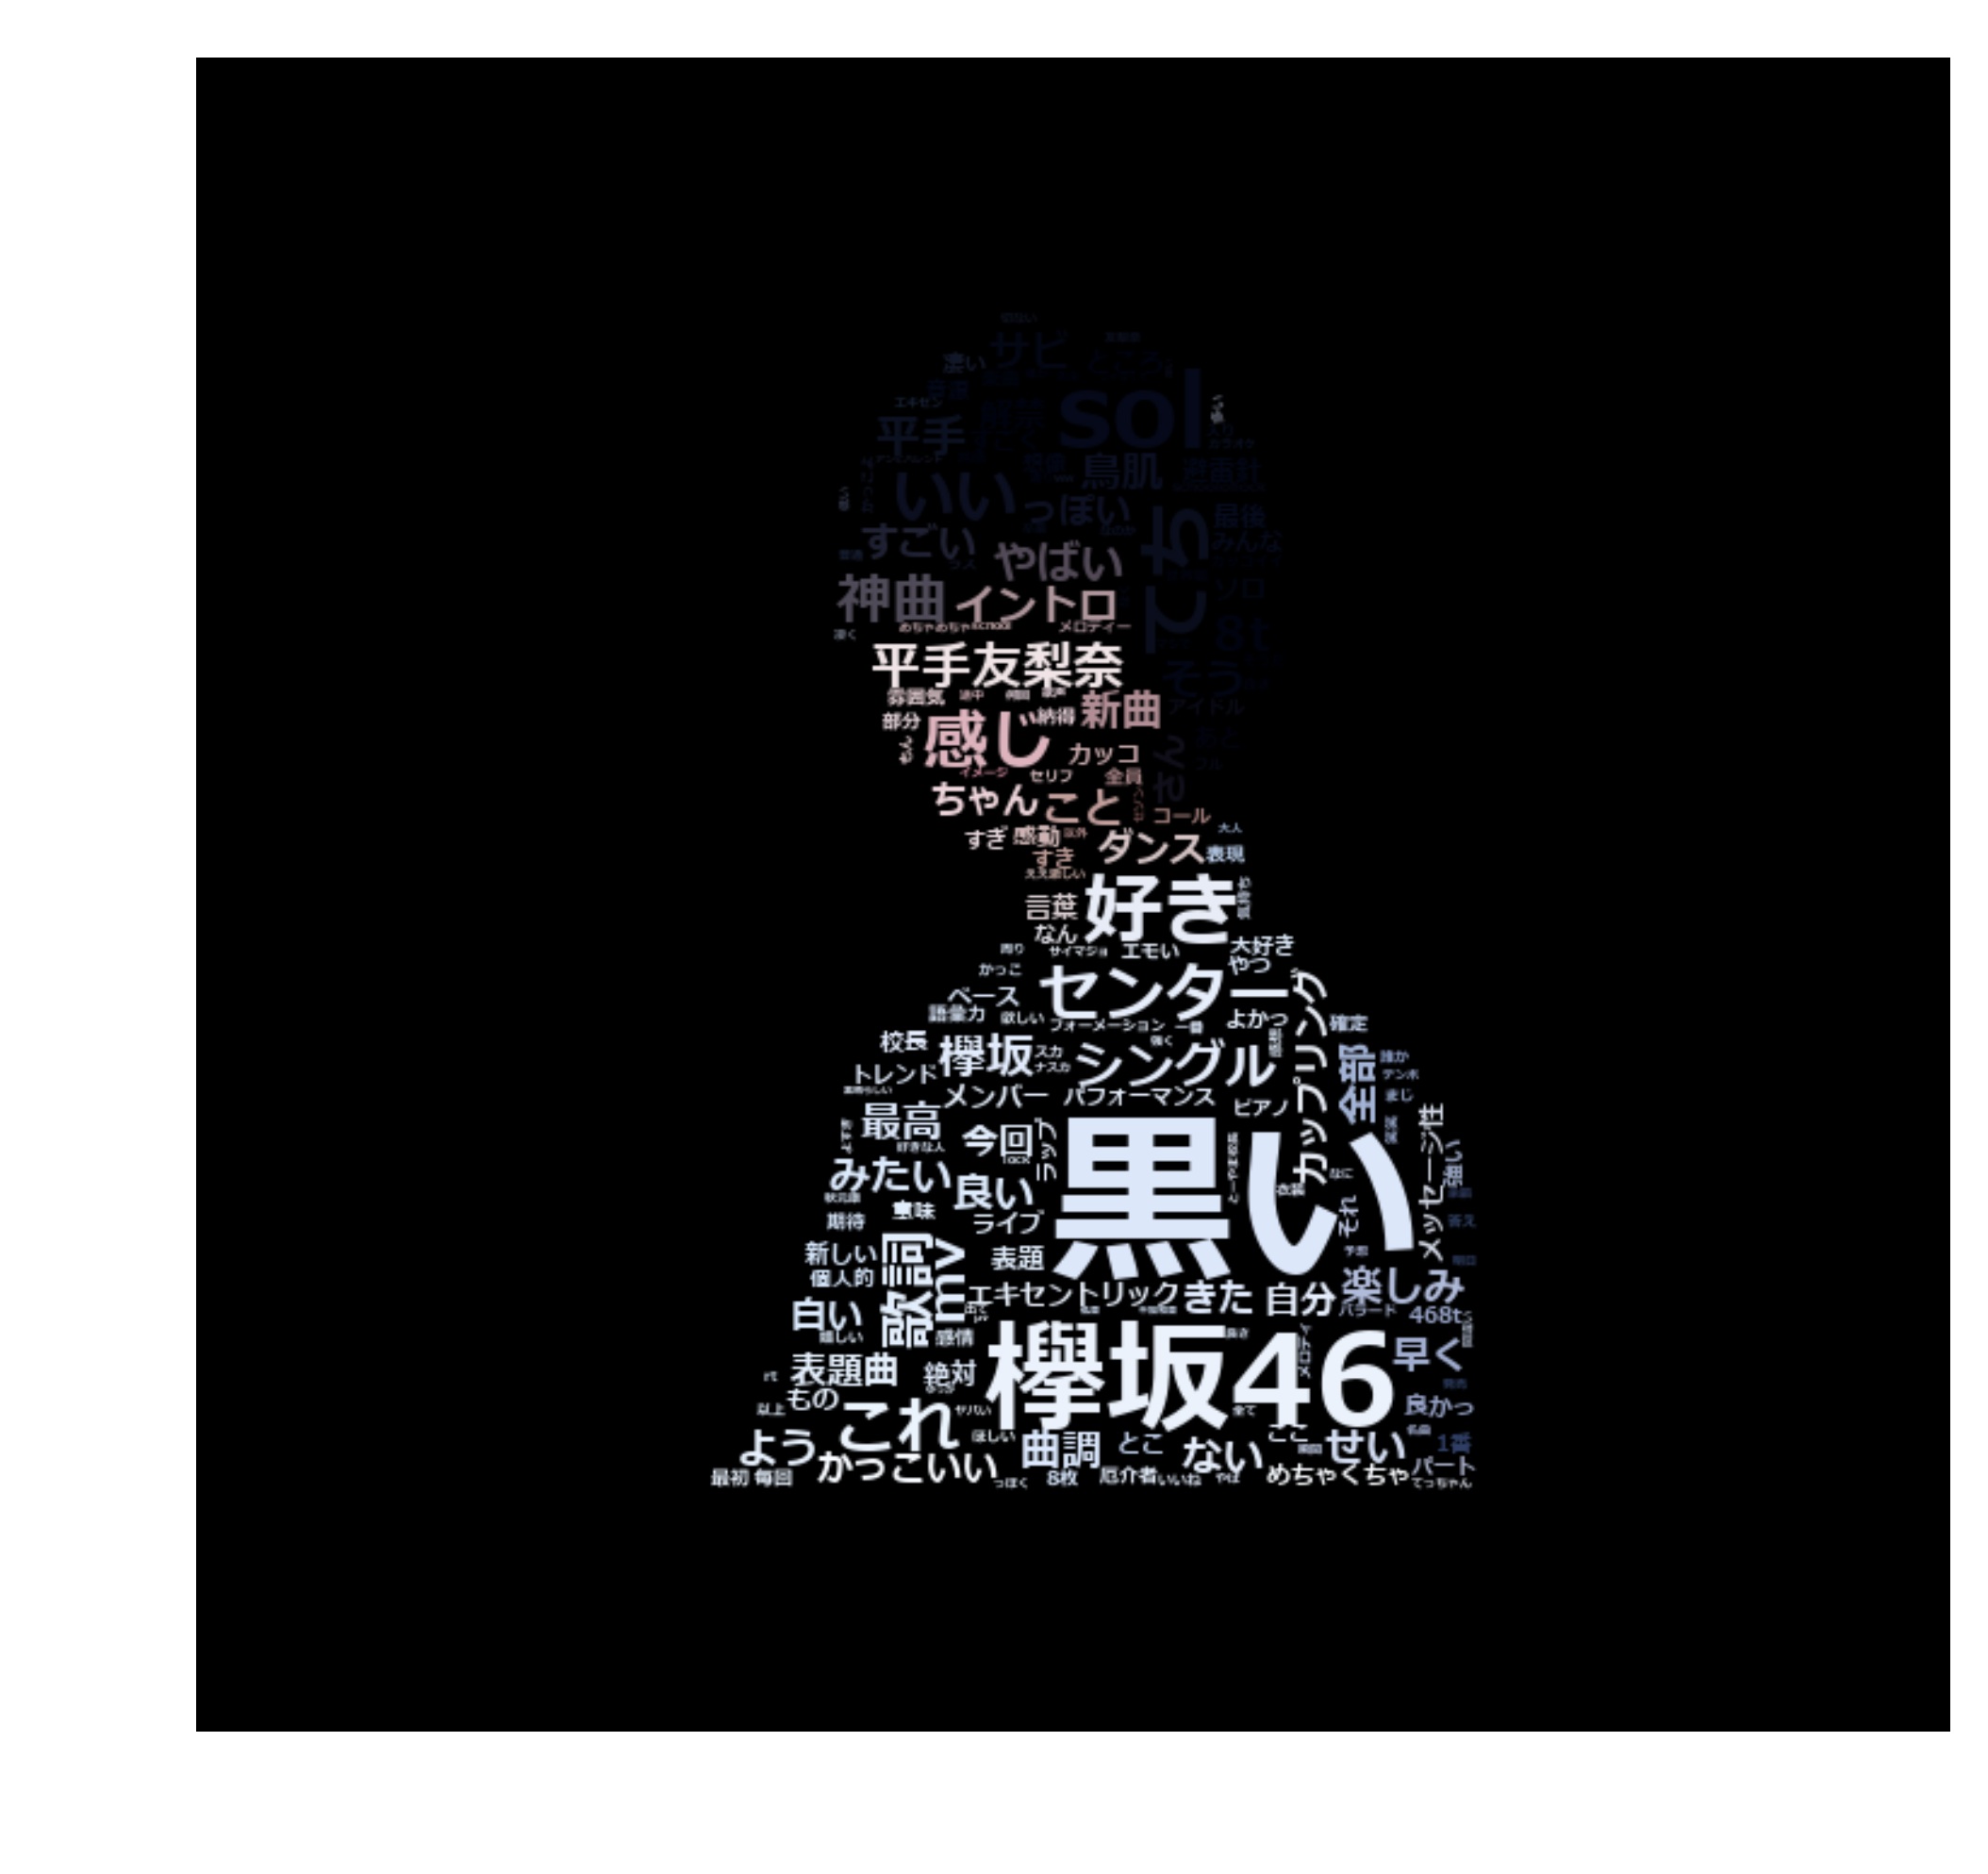

In [18]:
get_wordcrowd_color_mask(text, './mask_images/hirate-removebg_2.png')

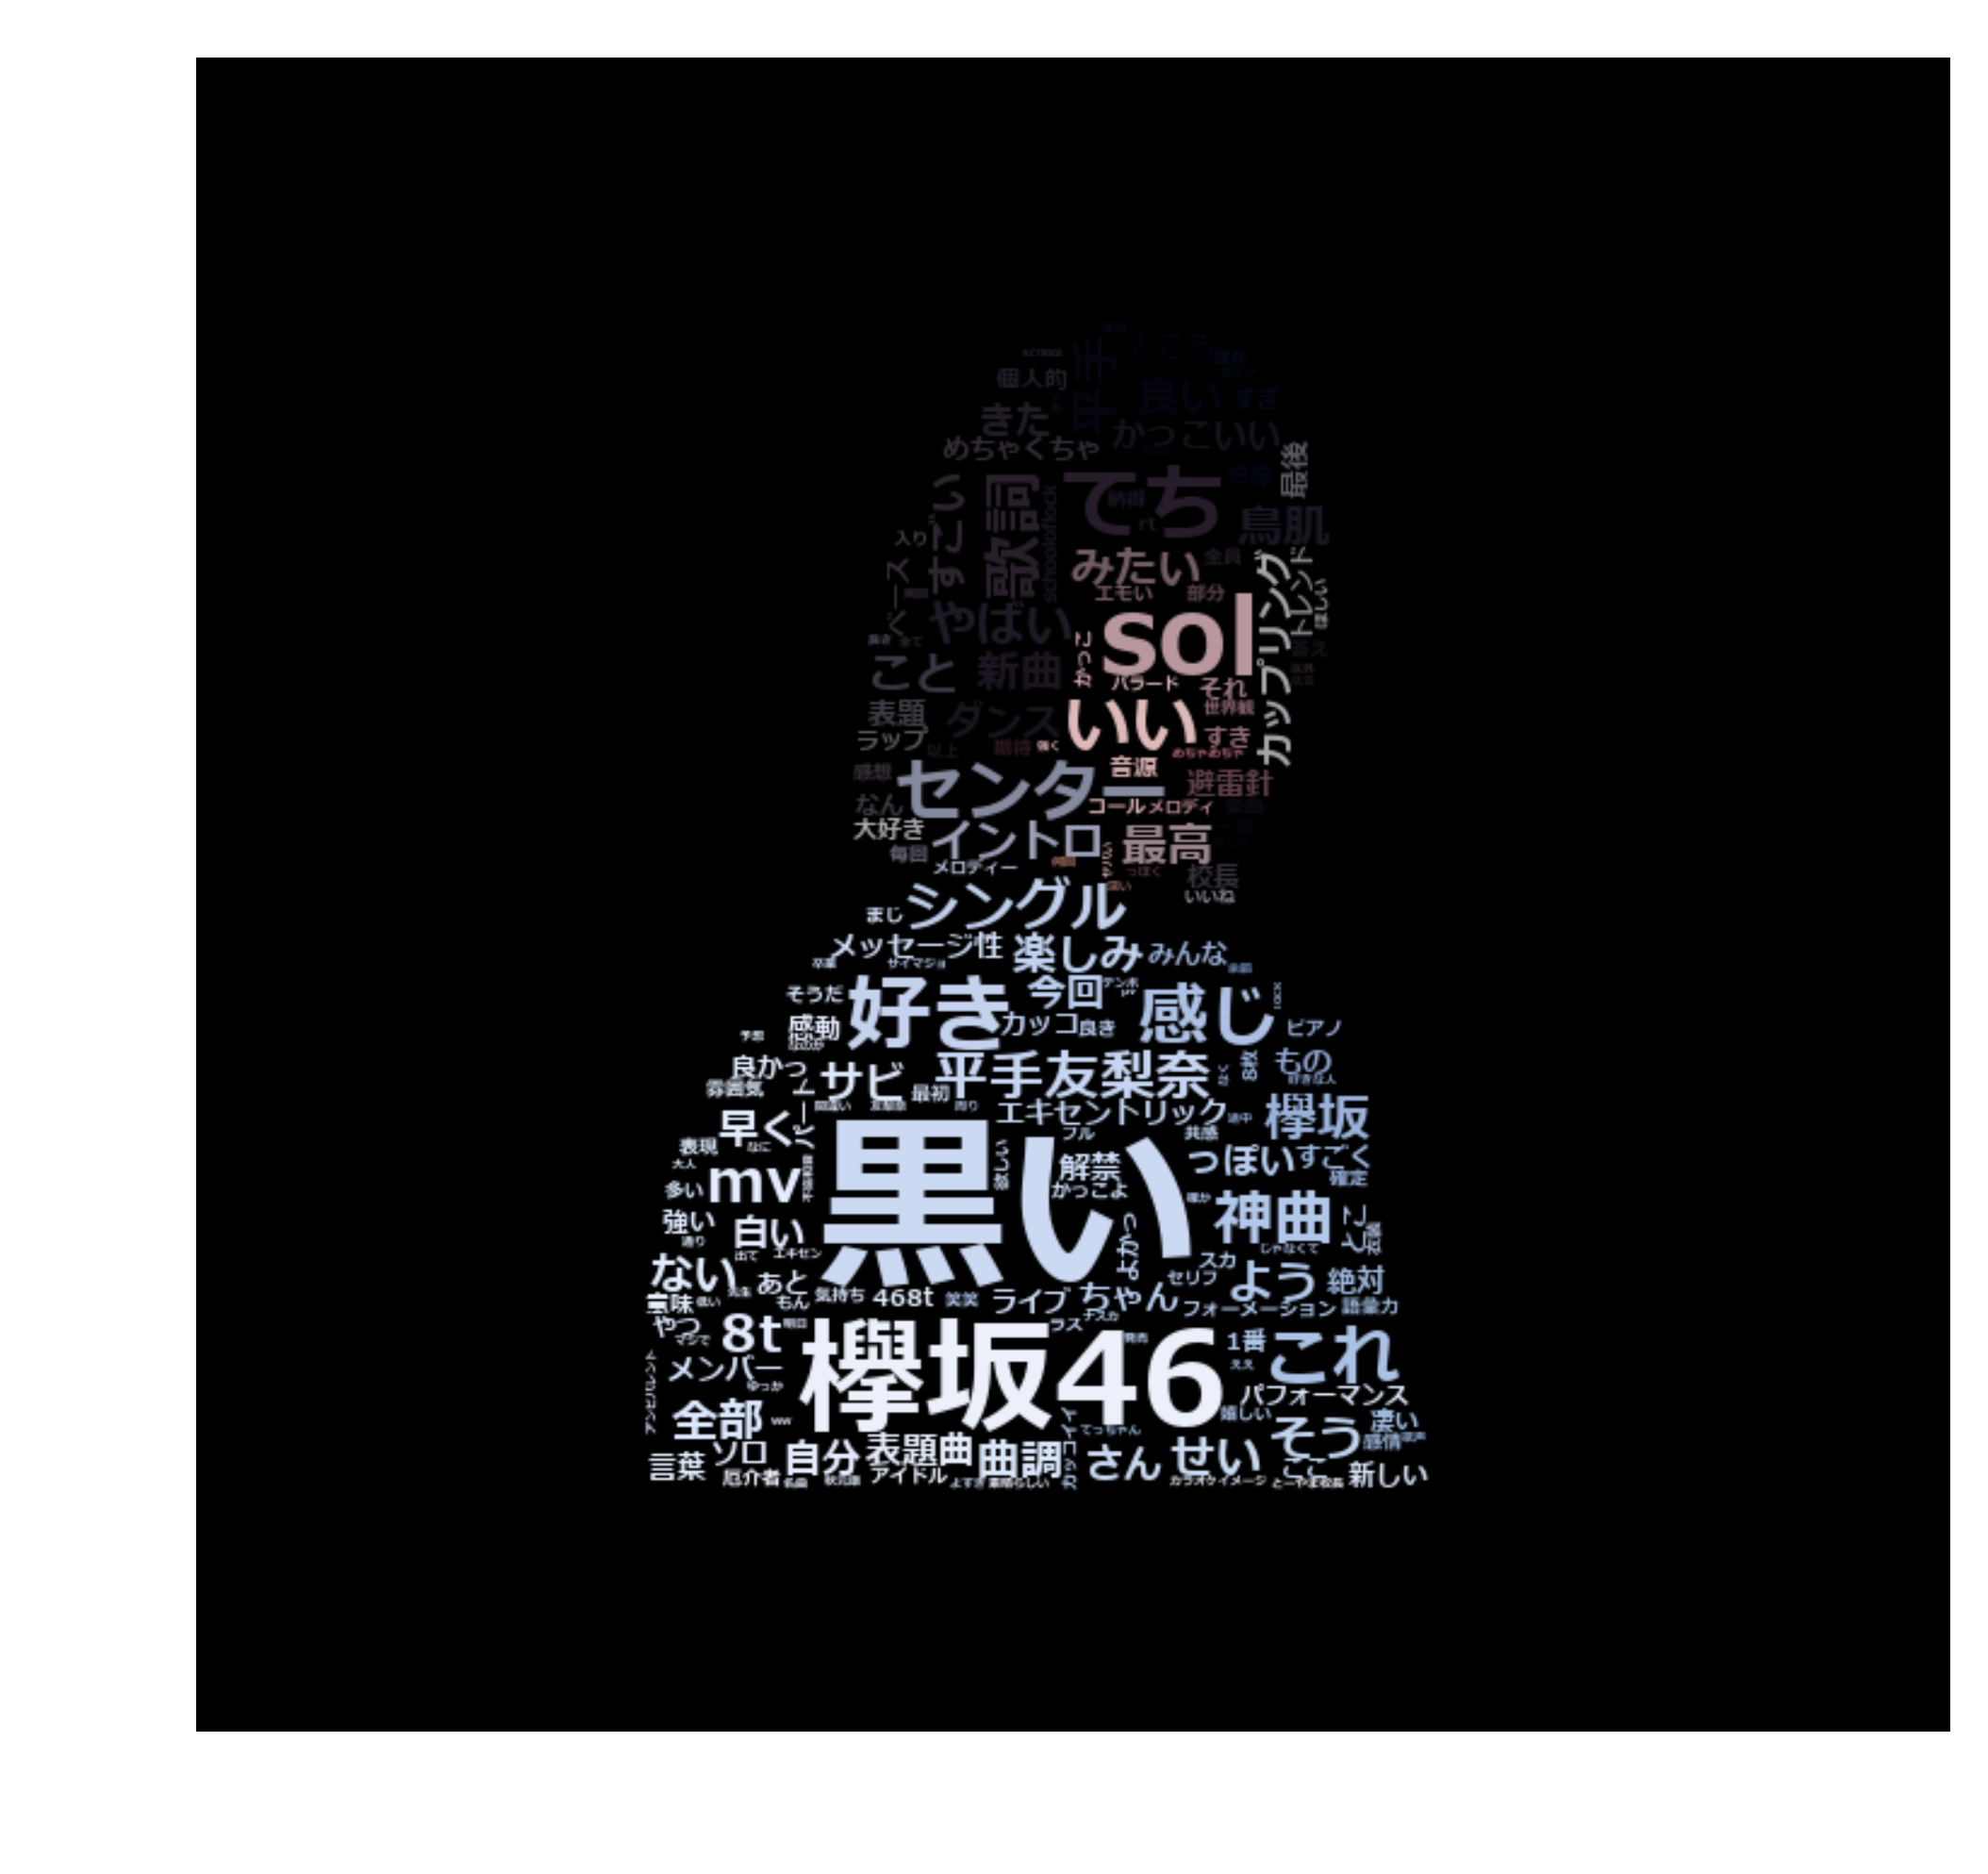

In [19]:
get_wordcrowd_color_mask(text, './mask_images/risa-removebg_2.png')